# **Spiking Neural Network**

Spiking neural networks are more biological inspired compared to traditional Aritifical Neural Network. Instead of continous signals, they send discrete spikes similar to action potentials in human neurons.

Below is my writeup of a Self Organizing Neural Network using spiking neurons. I utilize the Brian2 package and LIF equations for my model to analyze and sort the Iris Dataset of three different types of iris speicies

In [3]:
from brian2 import *

In [11]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
iris = load_iris()
data = iris.data
target = iris.target

# Normalize the features to a 0-1 range
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = data[::10] #Gets every 10th data point (5 for each type of flower)
print(data)

Matplotlib is building the font cache; this may take a moment.


[[0.22222222 0.625      0.06779661 0.04166667]
 [0.30555556 0.70833333 0.08474576 0.04166667]
 [0.30555556 0.58333333 0.11864407 0.04166667]
 [0.13888889 0.45833333 0.10169492 0.04166667]
 [0.19444444 0.625      0.05084746 0.08333333]
 [0.75       0.5        0.62711864 0.54166667]
 [0.19444444 0.         0.42372881 0.375     ]
 [0.44444444 0.5        0.6440678  0.70833333]
 [0.33333333 0.16666667 0.47457627 0.41666667]
 [0.33333333 0.25       0.57627119 0.45833333]
 [0.55555556 0.54166667 0.84745763 1.        ]
 [0.61111111 0.5        0.69491525 0.79166667]
 [0.72222222 0.5        0.79661017 0.91666667]
 [0.86111111 0.33333333 0.86440678 0.75      ]
 [0.66666667 0.45833333 0.77966102 0.95833333]]


In [9]:
def run_snn_on_data(sample) :
  start_scope() #Reset and clean environment
  # Set simulation parameters
  num_neurons = 12         # Number of neurons

  # Define neuron parameters
  tau = 10*ms               # Membrane time constant
  V_rest = -70*mV            # Resting potential
  V_reset = -70*mV           # Reset potential after firing
  V_threshold = -55*mV       # Firing threshold
  R_m = 10*Mohm             # Membrane resistance
  input_current = 4.0 * nA  # Constant input current to stimulate spiking


  # Define neuron model with LIF equations and noise in the current
  eqs = '''
  dv/dt = (-(v - V_rest) + R_m * (I)) / tau : volt (unless refractory)
  I : amp
  '''

  # Create the neuron group
  neuron_group = NeuronGroup(num_neurons, eqs, threshold='v > V_threshold',
                            reset='v = V_reset', refractory=5*ms, method='euler') #changed refractory from 5ms to 10ms

  # Initialize neuron parameters
  for m in range(num_neurons // len(sample)) :
    for n in range(len(sample)) :
      #Set each neuron group voltage proportional the the sample value w/ three copies
      neuron_group.v[len(sample) * m + n] = V_reset + sample[n] * ((V_threshold - V_reset) / 2)
  input_currents = sample * 10 * nA  # Scale normalized features for stronger input
  neuron_group.I = input_currents.mean()  # Apply mean current as input to neurons

  # Define STDP model for synaptic plasticity
  tau_pre = tau_post = 20*ms
  Apre = 0.01 #traces of pre-synaptic activity
  Apost = -Apre * 1.05 #traces of post-synaptic activity
  inhibition_strength = 2.0 * mV
  # Define synapse model with STDP rule
  S = Synapses(neuron_group, neuron_group,
              model='''
              w : 1                   # Synaptic weight
              dapre/dt = -apre / tau_pre : 1 (event-driven)
              dapost/dt = -apost / tau_post : 1 (event-driven)
              ''',
              on_pre='''
              v_post += w * mV        # Apply weight to post-synaptic neuron
              apre += Apre              # Update pre trace
              w = clip(w + apost, 0, 1)  # Apply STDP rule (restricting between 0, 1)
              v_post -= inhibition_strength #Apply inhibition on post-synaptic neuron
              ''',
              on_post='''
              apost += Apost             # Update post trace
              w = clip(w + apre, 0, 1)  # Apply STDP rule (restricting between 0, 1)
              ''')
  S.connect(condition='i != j')        # Connect all neurons except self-connections #Changed i != j to m != n
  S.w = 0.5


  spike_monitor = SpikeMonitor(neuron_group)  # Monitor for spike times
  state_monitor = StateMonitor(neuron_group, 'v', record=True)  # Monitor membrane potential
  weight_monitor = StateMonitor(S, ['w', 'apre', 'apost'], record=True)  # Monitor synaptic weights and traces
  run(20*ms)
  return spike_monitor


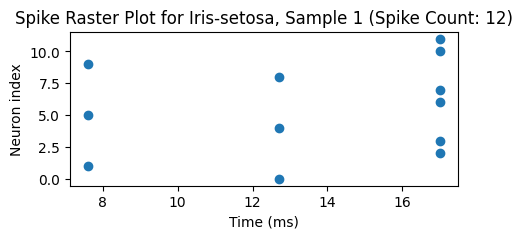

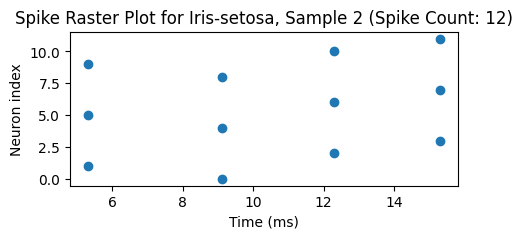

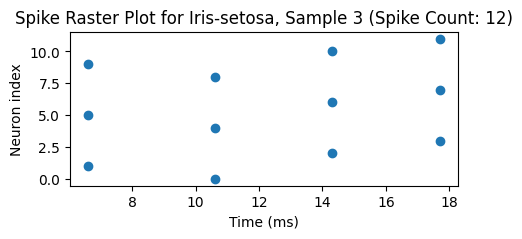

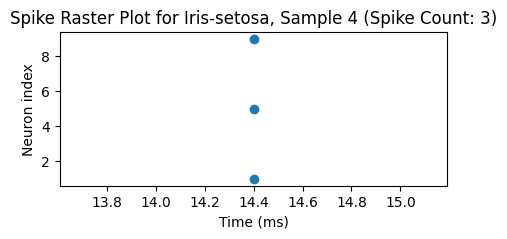

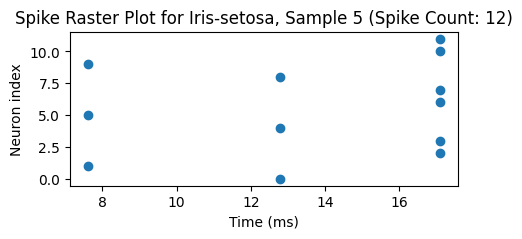

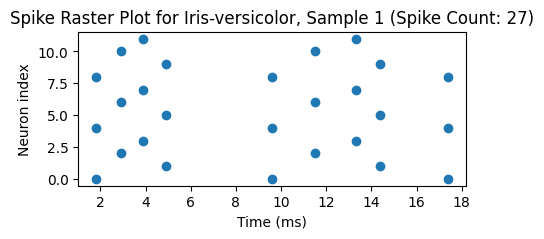

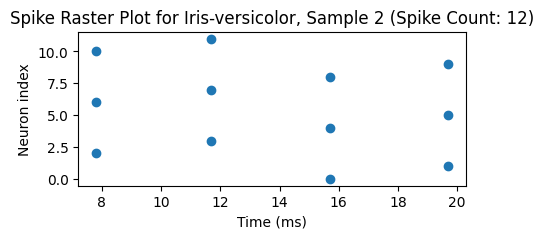

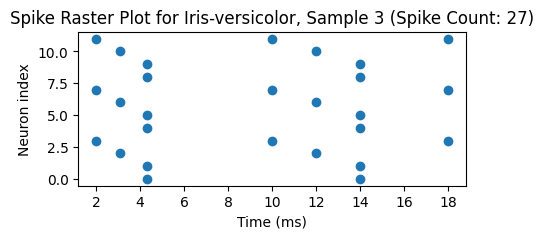

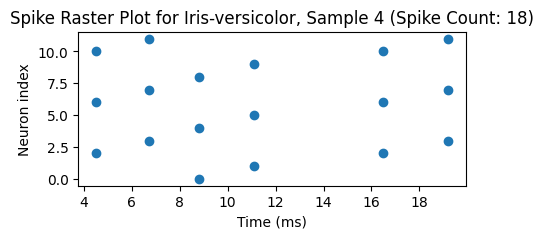

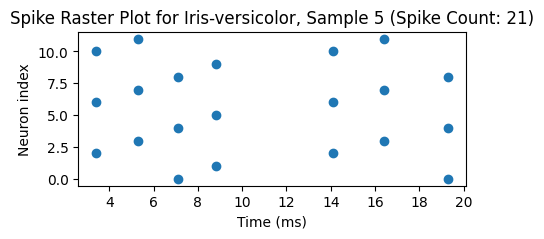

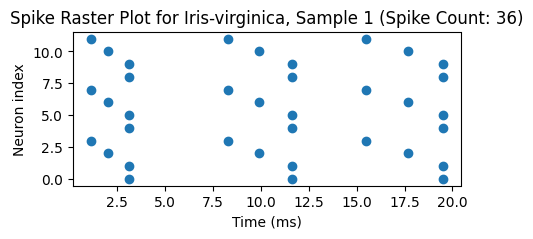

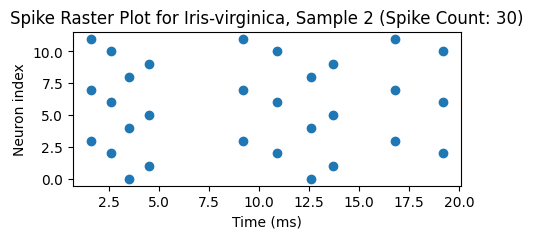

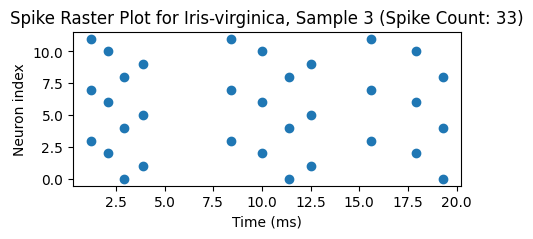

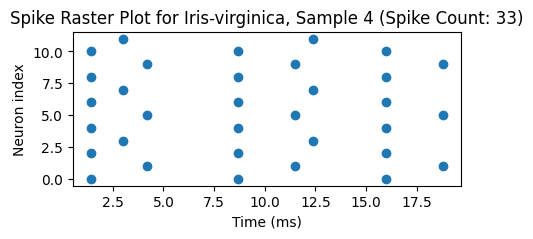

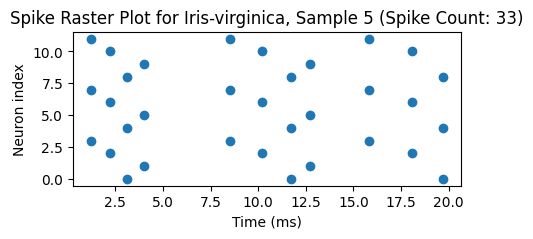

In [12]:
# Run the SONN on each sample in the Iris dataset
count = 0
flowers = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
for sample in data:
    #Get the spike_monitor for the SONN
    spike_monitor = run_snn_on_data(sample)
    #Plot the Spike_points
    plt.figure(figsize=(5, 2))
    plt.scatter(spike_monitor.t/ms, spike_monitor.i)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    flower_name = flowers[count // 5]
    plt.title(f'Spike Raster Plot for {flower_name}, Sample {count % 5 + 1} (Spike Count: {len(spike_monitor)})')
    plt.show()
    count += 1

Analyzing the spike counter and general shape for each type of flower, we can see a similarity arrising between flowers of the same type. Iris-setosa seem to show the least amount of spikes with an average of 8-16 spikes, Iris-versicolor show the second least amount of spikes with an average of 18-30 spikes, and Iris-viriginica show the most amont of spikes with an average of 30-40. Even though the graph produces some outliers (i.e Iris-setosa Sample 4 and Iris-versicolor Sample 2), the neurons in the SONN follow this general trend which helps to verify that our model is producing expected results.

# **References**



Brian2 Documentation: https://brian2.readthedocs.io/en/stable/

Spiking Neuron Video: https://www.youtube.com/watch?v=9dYZXQl4ozk

Leaky-Integrate-and-File Neuron: http://www.kaizou.org/2018/07/lif-neuron-tensorflow.html#:~:text=Leaky%2Dintegrate%2Dand%2Dfire,can%20be%20analyzed%20and%20simulated.

Iris Dataset: https://www.kaggle.com/datasets/uciml/iris